In [1]:
import pandas as pd
from IPython.display import Audio as aud
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cremadf = pd.read_csv('datasets/crema.csv')
ravdessdf = pd.read_csv('datasets/ravdess.csv')
saveedf = pd.read_csv('datasets/savee.csv')
tessdf = pd.read_csv('datasets/tess.csv')

In [3]:
data = pd.concat([cremadf, ravdessdf, saveedf, tessdf])

In [4]:
data.shape

(23076, 2)

In [5]:
data['sentiment'].value_counts()

sentiment
neutral     7692
positive    7692
negative    7692
Name: count, dtype: int64

In [6]:
wav, sr = librosa.load(data.iloc[0]['file_path'], sr=16000)
print('sentiment: ' + data.iloc[0]['sentiment'])
aud(wav, rate=sr)

sentiment: neutral


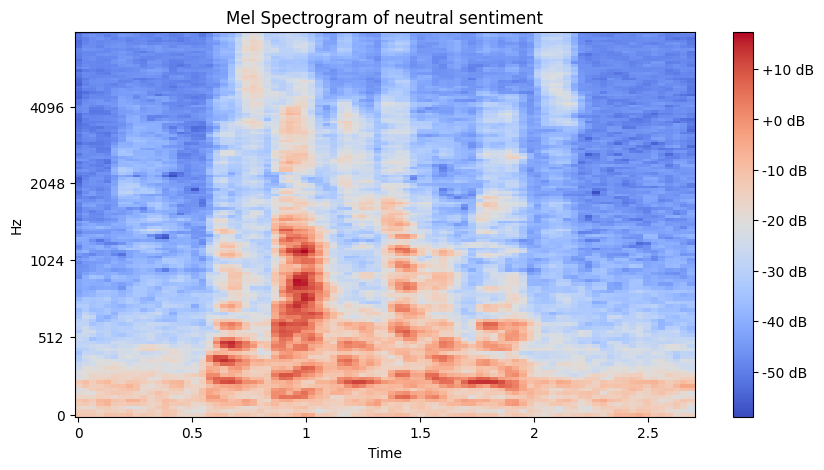

In [7]:
# sample
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time')
plt.title(f'Mel Spectrogram of {data.iloc[0]['sentiment']} sentiment')
plt.colorbar(format='%+2.0f dB')
plt.show()

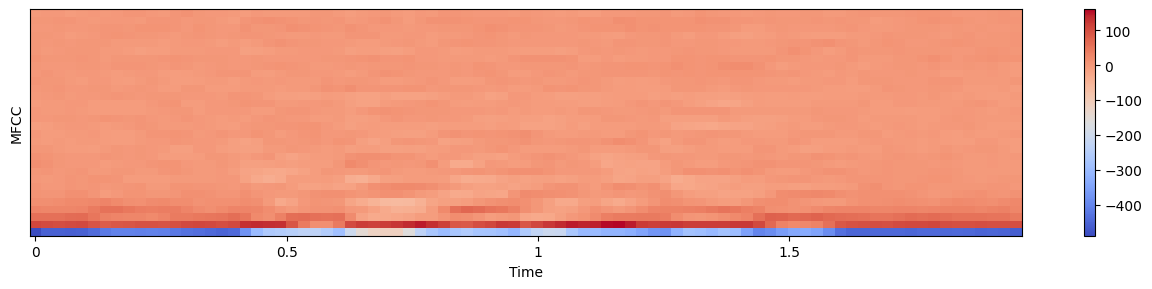

In [8]:
mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=30)

# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

In [9]:
# Augmentations
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [10]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=16000,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result


def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [11]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [12]:
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Step 1: Split paths and emotions BEFORE extracting features
train_paths, test_paths, train_emotions, test_emotions = train_test_split(
    data.file_path, data.sentiment, test_size=0.2, stratify=data.sentiment, random_state=42
)

# Step 2: Process training data with augmentations
def process_train(path, emotion):
    features = get_features(path)  # includes 4 versions
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

# Step 3: Process test data WITHOUT augmentation (just original audio)
def process_test(path, emotion):
    data, sr = librosa.load(path, duration=2.5, offset=0.6)
    feat = extract_features(data)
    return feat, emotion

# Extract training data with augmentation
train_results = Parallel(n_jobs=-1)(delayed(process_train)(path, emotion) for path, emotion in zip(train_paths, train_emotions))

X_train, Y_train = [], []
for x, y in train_results:
    X_train.extend(x)
    Y_train.extend(y)

# Extract test data without augmentation
test_results = Parallel(n_jobs=-1)(delayed(process_test)(path, emotion) for path, emotion in zip(test_paths, test_emotions))

X_test, Y_test = [], []
for x, y in test_results:
    X_test.append(x)
    Y_test.append(y)

# Save to DataFrames or CSVs
df_train = pd.DataFrame(X_train)
df_train['Emotions'] = Y_train
df_train.to_csv('train_emotions.csv', index=False)

df_test = pd.DataFrame(X_test)
df_test['Emotions'] = Y_test
df_test.to_csv('test_emotions.csv', index=False)


In [1]:
# Created by DaBloat